Trabalho sobre análise exploratória de dados utilizando Python, Linguagem SQL e Banco de Dados SQLite. 
Os dados utilizados nesse projeto são dados reais, disponíveis a partir do IMDB.

Realizando a instalação e carregamento dos pacotes a serem utilizados

In [1]:
# Instalando o pacote
!pip install -q imdb-sqlite

In [2]:
# instalando o pacote pycountry (nomes dos paises, etc...)
!pip install -q pycountry

In [3]:
# Importando pacotes para realização das análises numéricas

import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

Carregamento dos Dados utilizados

In [4]:
%%time
!imdb-sqlite

2022-03-15 21:38:40,201 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads/name.basics.tsv.gz
2022-03-15 21:39:14,898 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads/title.basics.tsv.gz
2022-03-15 21:39:34,836 GET https://datasets.imdbws.com/title.akas.tsv.gz -> downloads/title.akas.tsv.gz
2022-03-15 21:40:09,033 GET https://datasets.imdbws.com/title.principals.tsv.gz -> downloads/title.principals.tsv.gz
2022-03-15 21:41:02,233 GET https://datasets.imdbws.com/title.episode.tsv.gz -> downloads/title.episode.tsv.gz
2022-03-15 21:41:10,918 GET https://datasets.imdbws.com/title.ratings.tsv.gz -> downloads/title.ratings.tsv.gz
2022-03-15 21:41:11,356 Populating database: imdb.db
2022-03-15 21:41:11,356 Applying schema
2022-03-15 21:41:11,357 Importing file: downloads/name.basics.tsv.gz
2022-03-15 21:41:11,357 Reading number of rows ...
2022-03-15 21:41:14,872 Inserting rows into table: people
100%|████████████████████████| 11484457/11484457 [01:02<00:00, 184084

In [5]:
# abrindo conexão ao banco de dados
conn = sqlite3.connect("imdb.db")

In [6]:
# Realizando a extração das listas de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [8]:
# type(tabelas)
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [10]:
tabelas = tabelas["Table_Name"].values.tolist()

In [12]:
# Verificando o esquema de cada tabela
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Primeira parte - Quais as categorias de filmes mais comuns no IMDB ?

In [15]:
# Criando a primeira consulta 
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [17]:
resultado1 = pd.read_sql_query(consulta1, conn)

In [18]:
# Total com base na categoria
display(resultado1)

,type,COUNT
0,movie,604670
1,short,860393
2,tvEpisode,6569786
3,tvMiniSeries,42557
4,tvMovie,135370
5,tvPilot,2
6,tvSeries,222271
7,tvShort,10503
8,tvSpecial,36277
9,video,258022


In [19]:
# Além de calcular o percentual, é necessário criar uma coluna nova
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [20]:
display(resultado1)

,type,COUNT,percentual
0,movie,604670,6.894400
1,short,860393,9.810134
2,tvEpisode,6569786,74.908189
3,tvMiniSeries,42557,0.485232
4,tvMovie,135370,1.543478
5,tvPilot,2,0.000023
6,tvSeries,222271,2.534317
7,tvShort,10503,0.119754
8,tvSpecial,36277,0.413628
9,video,258022,2.941947


In [21]:
# Filtrando apenas 4 categorias. 3 categorias com mais títulos e 1 categorias com o restante
others = {}

others['COUNT'] = resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

others['type'] = 'others'

In [22]:
others

{'COUNT': 735602, 'percentual': 8.387276777442802, 'type': 'others'}

In [23]:
resultado1 = resultado1[resultado1['percentual'] > 5]

In [24]:
resultado1 = resultado1.append(others, ignore_index=True)

In [25]:
resultado1 = resultado1.sort_values(by = 'COUNT', ascending=False)

In [26]:
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,6569786,74.908189
1,short,860393,9.810134
3,others,735602,8.387277
0,movie,604670,6.894400


In [27]:
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2)) +'%'+']' for i in resultado1.index]

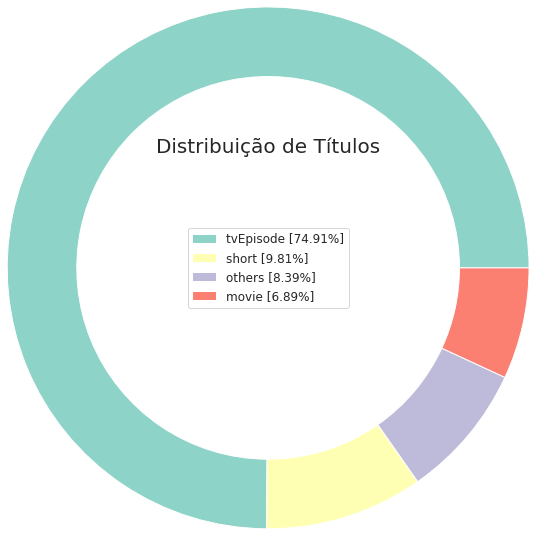

In [28]:
#Plot

cs = cm.Set3(np.arange(100))

f = plt.figure()

plt.pie(resultado1['COUNT'], labeldistance=1, radius=3, colors=cs, wedgeprops= dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict={'fontsize': 20, 'fontweight': 20})
plt.show()